In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub

In [2]:
df_data = pd.read_csv('../Data/data_2/clean_review.csv')
df_data

,text,rating,label
0,near airport with good shuttle service stay he...,2.0,negative
1,get a low ranking for a reason I have few posi...,1.0,negative
2,budget hotel pretend to be a resort the hanale...,2.0,negative
3,dish out a few extra buck and stay elsewhere t...,1.0,negative
4,l a on a budget the good low cost for a brand ...,2.0,negative
...,...,...,...
62866,could not ask for a well hotel experience grea...,5.0,positive
62867,a little gem we be not stay in GPE DATE DATE f...,5.0,positive
62868,love my night in the ORG great location clean ...,5.0,positive
62869,a great experience just return from a night st...,5.0,positive


In [3]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer()
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

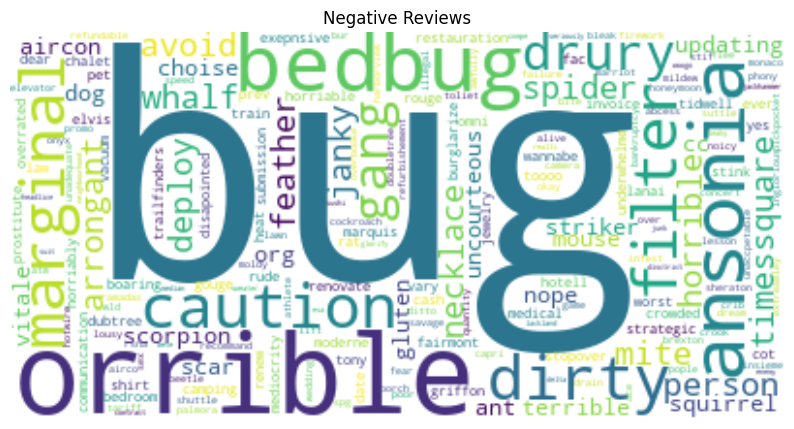

In [4]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


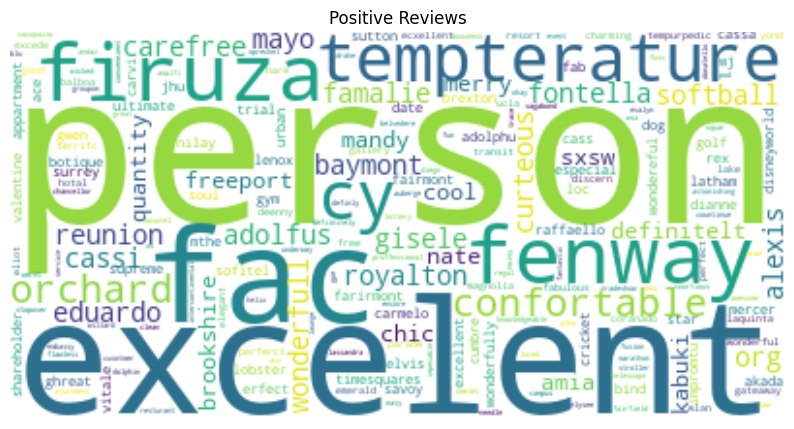

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


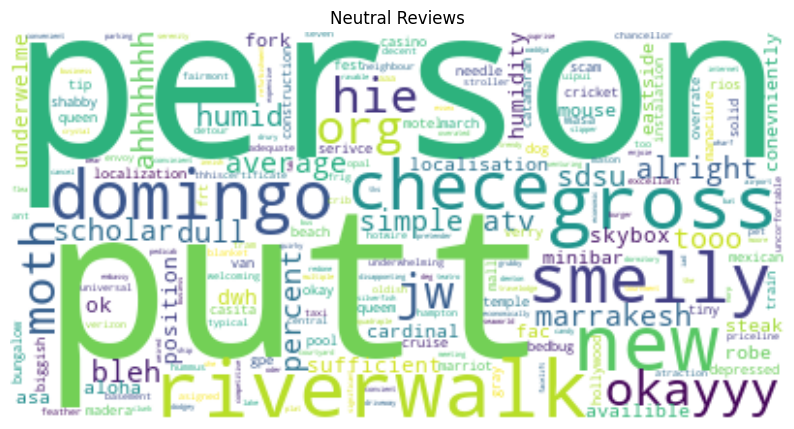

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [7]:
encoding_5label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [8]:
df_data['label'] = df_data['label'].map(encoding_5label)
df_data

,text,rating,label
0,near airport with good shuttle service stay he...,2.0,2
1,get a low ranking for a reason I have few posi...,1.0,2
2,budget hotel pretend to be a resort the hanale...,2.0,2
3,dish out a few extra buck and stay elsewhere t...,1.0,2
4,l a on a budget the good low cost for a brand ...,2.0,2
...,...,...,...
62866,could not ask for a well hotel experience grea...,5.0,0
62867,a little gem we be not stay in GPE DATE DATE f...,5.0,0
62868,love my night in the ORG great location clean ...,5.0,0
62869,a great experience just return from a night st...,5.0,0


In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((50296,), (6287,), (50296,), (6287,), (6288,), (6288,))

In [10]:
EMBEDDING_DIM = 100
MAXLEN = 1000
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 70000
NUM_LABELS = 3

In [11]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_val_pad = pad_sequences(x_val_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [12]:
x_train_tensor = tf.convert_to_tensor(x_train)
y_train_tensor = tf.convert_to_tensor(y_train)
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)
x_val_tensor = tf.convert_to_tensor(x_val)
y_val_tensor = tf.convert_to_tensor(y_val)

In [15]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 124,692,355
Trainable params: 124,692,355
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train_tensor, y_train_tensor, epochs=10, batch_size=256, validation_data=(x_test_tensor, y_test_tensor))

Epoch 1/10
197/197 [==============================] - 297s 2s/step - loss: 0.5924 - accuracy: 0.7412 - val_loss: 0.5042 - val_accuracy: 0.7829
Epoch 2/10
197/197 [==============================] - 288s 1s/step - loss: 0.4619 - accuracy: 0.8067 - val_loss: 0.5048 - val_accuracy: 0.7816
Epoch 3/10
197/197 [==============================] - 280s 1s/step - loss: 0.4157 - accuracy: 0.8296 - val_loss: 0.5239 - val_accuracy: 0.7741
Epoch 4/10
197/197 [==============================] - 251s 1s/step - loss: 0.3751 - accuracy: 0.8491 - val_loss: 0.5596 - val_accuracy: 0.7743
Epoch 5/10
197/197 [==============================] - 249s 1s/step - loss: 0.3384 - accuracy: 0.8663 - val_loss: 0.5795 - val_accuracy: 0.7625
Epoch 6/10
197/197 [==============================] - 246s 1s/step - loss: 0.2986 - accuracy: 0.8841 - val_loss: 0.6231 - val_accuracy: 0.7587
Epoch 7/10
197/197 [==============================] - 243s 1s/step - loss: 0.2640 - accuracy: 0.8995 - val_loss: 0.6927 - val_accuracy: 0.7504

In [17]:
val_loss, val_accuracy = model.evaluate(x_val_tensor, y_val_tensor)

197/197 [==============================] - 24s 121ms/step - loss: 0.9787 - accuracy: 0.7400


In [18]:
print(f'Validation accuracy: {val_accuracy}, Validation loss: {val_loss}')

Validation accuracy: 0.739980936050415, Validation loss: 0.9786590337753296


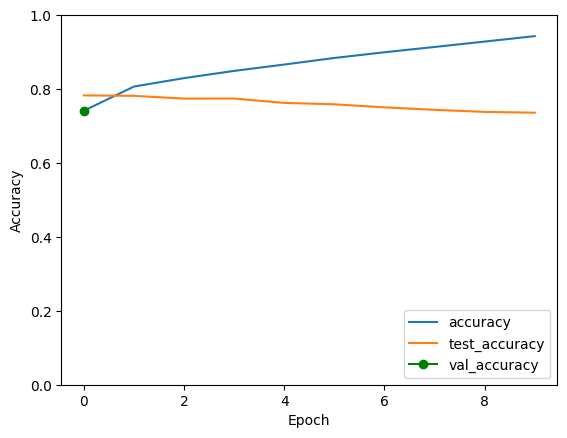

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [20]:
# df_history_train = pd.DataFrame({
#     ' ': ['positive', 'negative'],
#     'positive': [history.history['true_positives_6'][-1], history.history['false_negatives_6'][-1]],
#     'negative' : [history.history['false_positives_6'][-1], history.history['true_negatives_6'][-1]]
# })

# df_history_val = pd.DataFrame({
#     ' ': ['positive', 'negative'],
#     'positive': [history.history['val_true_positives_6'][-1], history.history['val_false_negatives_6'][-1]],
#     'negative' : [history.history['val_false_positives_6'][-1], history.history['val_true_negatives_6'][-1]]
# })

# display(df_history_train)
# display(df_history_val)

In [21]:
embeddings = model.layers[0].get_weights()[0]
pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=35).fit_transform(pca)

magnitudes = np.linalg.norm(embeddings, axis=1)
top_indices = magnitudes.argsort()[-200:]
top_words = {word: index for word, index in word_index.items() if index in top_indices}

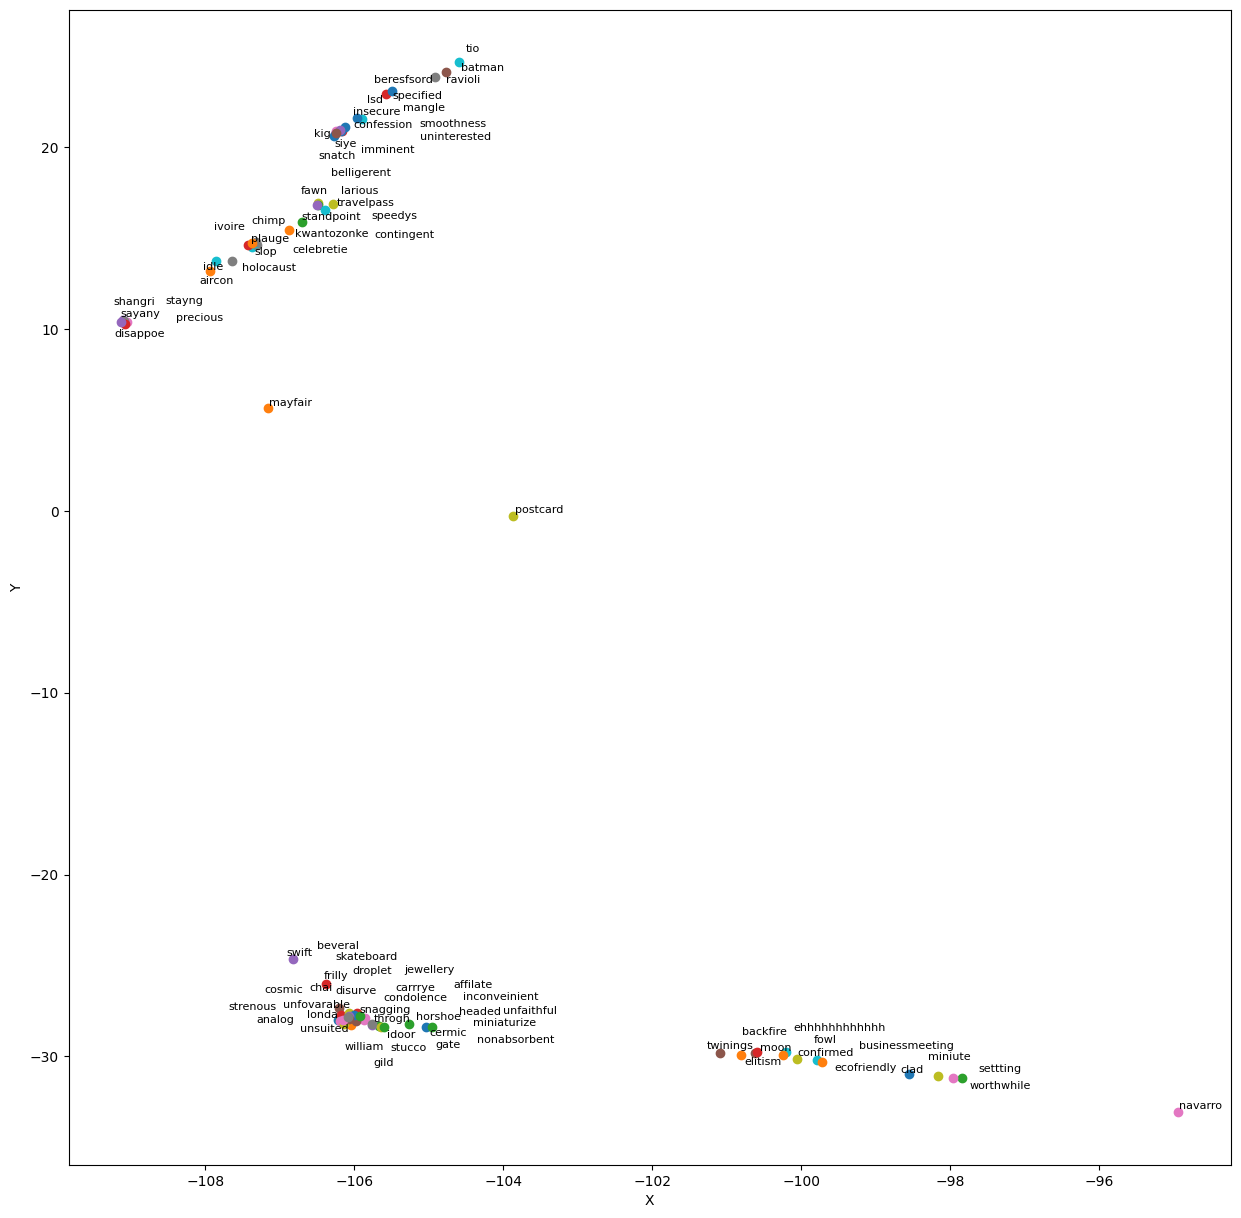

In [22]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for word, index in top_words.items():
    x, y = embeddings_2d[index]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
adjustText.adjust_text(ax.texts,iterations=100)

plt.show()

In [23]:
model.save('model_2.h5')